# **Inner Evaluation: Kmeans**

## **Requirements**

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from  xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')

In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyML_Package_Private')
from PyML.preprocessing import encoder, imputer, scaler, features_selector
from PyML.evaluation import SimpleEvaluation


In [3]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.models import MiniBatchKmeansEstimator
from FastKmedoids.data import sort_predictors_for_GG

## **Data**

In [4]:
madrid_houses_df = pl.read_csv('Data/madrid_houses_NaNS.csv')
variables_to_remove = ['', 'id', 'district', 'neighborhood', 'sq_mt_allotment']
variables_to_keep = [x for x in madrid_houses_df.columns if x not in variables_to_remove]
madrid_houses_df = madrid_houses_df[variables_to_keep]
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,i64,i64,i64,i64,i64,bool,bool,bool,i64,bool,i64
64.0,2,1,1,3,85000,false,false,true,4,false,1
70.0,3,1,1,4,129900,true,true,true,0,false,1
94.0,2,2,1,1,144247,false,true,true,0,false,1
64.0,2,1,1,-1,109900,false,true,true,0,false,1
108.0,2,2,1,4,260000,false,true,true,0,true,1


In [5]:
quant_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors', 'buy_price']
cat_columns = [x for x in madrid_houses_df.columns if x not in quant_columns]

response = 'buy_price'
quant_predictors = [x for x in quant_columns if x != response]
cat_predictors = [x for x in cat_columns if x != response]
predictors = quant_predictors + cat_predictors

In [6]:
cat_predictors_sorted, p1, p2, p3 = sort_predictors_for_GG(df=madrid_houses_df, quant_predictors=quant_predictors, cat_predictors=cat_predictors)

## **Response and Predictors**

In [7]:
Y = madrid_houses_df[response].to_pandas()
X = madrid_houses_df[predictors].to_pandas()
# The Null values of the Polars columns that are define as Object type by Pandas are treated as None and not as NaN (what we would like)
# The avoid this behavior the next step is necessary
X = X.fillna(value=np.nan)

## **Defining outer evaluation: train-test split**


In [8]:
# Defining the outer-evaluation: train-test split.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.90, random_state=123)
# We set a large train size since we are mainly interested in compare models not in estimating the feature performance (indeed, we could omit the test part and doing the inner eval. with the whole data)

## **Defining inner evaluation: K-Fold Cross Validation**

In [9]:
# Defining the inner-evaluation: K-fold cross validation
inner = KFold(n_splits=4, shuffle=True, random_state=111)

In [10]:
inner_score, best_params, inner_results = {}, {}, {}

## Example of usage

In [11]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True, method='iterative_median'))])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True, method='simple_most_frequent'))])

quant_cat_transformer = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                        ('cat', cat_pipeline, cat_predictors_sorted)])

In [12]:
# Defining estimators to be used in each cluster
estimators_RF_XGB_2_clusters = {0: RandomForestRegressor(random_state=123),
                                1: XGBRegressor(random_state=123)}

In [13]:
X_train = quant_cat_transformer.fit_transform(X_train)
X_test = quant_cat_transformer.transform(X_test)
X_train = pd.DataFrame(X_train, columns=quant_predictors + cat_predictors_sorted)
X_test = pd.DataFrame(X_test, columns=quant_predictors + cat_predictors_sorted)

In [14]:
minibatchkmeans_regressor = MiniBatchKmeansEstimator(estimators=estimators_RF_XGB_2_clusters, 
                                            n_clusters=2, random_state=123)

In [15]:
minibatchkmeans_regressor.fit(X=X_train, y=Y_train)
Y_test_hat = minibatchkmeans_regressor.predict(X_test)
mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test)

Clusters weights (proportions): [0.8888321 0.1111679]


189570.7263808632

## **Pipelines definition**

In [16]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True)),
                           ('scaler', scaler())
                          ])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True))
                        ])

quant_cat_preprocessing = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                          ('cat', cat_pipeline, cat_predictors_sorted)]) 

In [17]:
meta_models = {'XGB': XGBRegressor(random_state=123),
               'RF': RandomForestRegressor(random_state=123)}

clusters_RF = [0,2,4,6]
clusters_XGB = [1,3,5,7]
max_n_clusters = len(clusters_RF + clusters_XGB)

estimators_RF_XGB = {j: meta_models['RF'] for j in clusters_RF}
estimators_RF_XGB.update({j: meta_models['XGB'] for j in clusters_XGB}) 

clustering_estimator = MiniBatchKmeansEstimator(estimators=estimators_RF_XGB, 
                                       n_clusters=2)

pipeline_clustering_model = Pipeline([('preprocessing', quant_cat_preprocessing),
                                      ('features_selector', features_selector()),
                                      ('clustering_model', clustering_estimator)
                                     ]) 

## **Grids for HPO**

In [18]:
def preprocessing_param_grid(trial):

    # Fix Grid
    param_grid = {
        'preprocessing__quant__imputer__method': trial.suggest_categorical('preprocessing__quant__imputer__method', ['simple_mean', 'simple_median', 'iterative_mean', 'iterative_median']),
        'preprocessing__cat__imputer__method': trial.suggest_categorical('preprocessing__cat__imputer__method', ['simple_most_frequent']),
        'preprocessing__quant__scaler__apply': trial.suggest_categorical('preprocessing__quant__scaler__apply', [True, False]),
        'preprocessing__cat__encoder__method': trial.suggest_categorical('preprocessing__cat__encoder__method', ['ordinal', 'one-hot']),   
        'features_selector__apply': trial.suggest_categorical('features_selector__apply', [False, True])  
        }

    # Conditioned Grid
    if param_grid['features_selector__apply'] == True:

        param_grid.update({'features_selector__method': trial.suggest_categorical('features_selector__method', 
                                                                                  ['Fdr_f_reg', 'Fpr_f_reg', 'KBest_f_reg', 'Percentile_f_reg'
                                                                                   #'forward_linear_reg', # Takes too much time with one-hot (too many predictors)
                                                                                   #'backward_linear_reg' # Takes too much time with one-hot (too many predictors)
                                                                                   ])})

        if param_grid['features_selector__method'] == 'KBest_f_reg':

            param_grid.update({'features_selector__k': trial.suggest_categorical('features_selector__k', [3, 5, 7, 8, 10])})

        if param_grid['features_selector__method'] == 'Percentile_f_reg':

            param_grid.update({'features_selector__percentile': trial.suggest_categorical('features_selector__percentile', [30, 50, 75])})


    if param_grid['preprocessing__quant__scaler__apply'] == True:
    
        param_grid.update({'preprocessing__quant__scaler__method': trial.suggest_categorical('preprocessing__quant__scaler__method', ['standard', 'min-max'])})

    return param_grid

In [19]:
def param_grid_clustering_model(trial):

    param_grid = {
        'clustering_model__n_clusters': trial.suggest_int('clustering_model__n_clusters', 2, 8)
    }

    return param_grid

In [20]:
def param_grid_RF_XGB(trial):

    param_grid = preprocessing_param_grid(trial)
    param_grid.update(param_grid_clustering_model(trial))

    n_clusters = param_grid['clustering_model__n_clusters']

    for j in range(0, n_clusters): # Create grids only for the effective clusters

        # Grids for RF
        if j in clusters_RF:

            param_grid.update({
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_int(f'clustering_model__estimators__{j}__n_estimators', 50, 120),
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__min_samples_split': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_split', 2, 25),
                f'clustering_model__estimators__{j}__min_samples_leaf': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_leaf', 2, 25)
            })

        # Grids for XGB
        if j in clusters_XGB:  

            param_grid.update({
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__lambda': trial.suggest_float(f'clustering_model__estimators__{j}__lambda', 0, 0.5, step=0.1, log=False),
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_categorical(f'clustering_model__estimators__{j}__n_estimators', [30, 50, 70, 100, 150, 180]),
                f'clustering_model__estimators__{j}__eta': trial.suggest_float(f'clustering_model__estimators__{j}__eta', 0, 0.3, step=0.02, log=False),
                f'clustering_model__estimators__{j}__alpha': trial.suggest_float(f'clustering_model__estimators__{j}__alpha', 0.2, 1, step=0.01, log=False)
            })

    return param_grid

## **HPO**

In [21]:
simple_eval = SimpleEvaluation(estimator=pipeline_clustering_model,  
                                inner=inner, 
                                param_grid=param_grid_RF_XGB,
                                search_method='optuna',
                                scoring='neg_mean_absolute_error', 
                                direction='maximize', 
                                n_trials=40, 
                                random_state=666)

simple_eval.fit(X=X_train, y=Y_train)

[I 2024-04-17 11:45:57,693] A new study created in memory with name: no-name-e134caaa-49d2-4c14-9c54-73ef269c508d


Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 11:46:43,494] Trial 0 finished with value: -436124.6987498269 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Fpr_f_reg', 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.08, 'clustering_model__estimators__1__alpha': 0.65}. Best is trial 0 with value: -436124.6987498269.


Clusters weights (proportions): [0.14066653 0.798746   0.04791113 0.01267634]
Clusters weights (proportions): [0.62661851 0.099632   0.25630367 0.01744582]
Clusters weights (proportions): [0.70771432 0.01560583 0.07468993 0.20198991]
Clusters weights (proportions): [0.3262914  0.03243833 0.12143928 0.51983099]


[I 2024-04-17 11:47:24,664] Trial 1 finished with value: -225973.35426895798 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.0, 'clustering_model__estimators__1__alpha': 0.78, 'clustering_model__estimators__2__n_estimators': 50, 'clustering_model__estimators__2__max_depth': 20, 'clustering_model__estimators__2__min_samples_split': 6,

Clusters weights (proportions): [0.42554352 0.01553874 0.09200572 0.2424862  0.0528181  0.17160771]
Clusters weights (proportions): [0.01478806 0.45904321 0.08525283 0.05199673 0.15203762 0.23688156]
Clusters weights (proportions): [0.21091727 0.01765027 0.06446777 0.11544228 0.23545046 0.35607196]
Clusters weights (proportions): [0.28281314 0.03441461 0.14338285 0.00858662 0.08314025 0.44766253]


[I 2024-04-17 11:48:04,254] Trial 2 finished with value: -237850.8636629684 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 6, 'clustering_model__estimators__0__n_estimators': 77, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.12, 'clustering_model__estimators__1__alpha': 0.8400000000000001, 'clustering_model__estimators__2__n_estimators': 54, 'clustering_model__estimators__2__max_depth': 50, 'clustering_model__estimators__2__min_sampl

Clusters weights (proportions): [0.42554352 0.01553874 0.09200572 0.2424862  0.0528181  0.17160771]
Clusters weights (proportions): [0.01478806 0.45904321 0.08525283 0.05199673 0.15203762 0.23688156]
Clusters weights (proportions): [0.20764618 0.01765027 0.06446777 0.11912226 0.23783563 0.35327791]
Clusters weights (proportions): [0.28281314 0.03441461 0.14338285 0.00858662 0.08314025 0.44766253]


[I 2024-04-17 11:48:56,065] Trial 3 finished with value: -623791.0039057308 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Percentile_f_reg', 'features_selector__percentile': 50, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 6, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.26, 'clustering_model__estimators__1__alpha': 0.33, 'clustering_model__estim

Clusters weights (proportions): [0.54446943 0.08587201 0.03094118 0.11435971 0.22435766]
Clusters weights (proportions): [0.16696197 0.28962791 0.02685021 0.42619599 0.09036391]
Clusters weights (proportions): [0.08995502 0.62396075 0.01029031 0.23531416 0.04047976]
Clusters weights (proportions): [0.46572168 0.0301213  0.14713098 0.26618509 0.09084094]


[I 2024-04-17 11:49:44,236] Trial 4 finished with value: -223834.05058343627 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Fdr_f_reg', 'clustering_model__n_clusters': 5, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.08, 'clustering_model__estimators__1__alpha': 0.32, 'clustering_model__estimators__2__n_estimators': 98, 'clustering_model__estimators__2__max_depth': 10, 'clustering_mo

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 11:51:26,429] Trial 5 finished with value: -201033.3767351272 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.24, 'clustering_model__estimators__1__alpha': 0.43000000000000005}. Best is trial 5 with value: -201033.3767351272.


Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 11:52:19,116] Trial 6 finished with value: -425066.7027996639 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'Fdr_f_reg', 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.06, 'clustering_model__estimators__1__alpha': 0.27}. Best is trial 5 with value: -201033.3767351272.


Clusters weights (proportions): [0.54446943 0.08587201 0.03094118 0.11435971 0.22435766]
Clusters weights (proportions): [0.16696197 0.28962791 0.02685021 0.42619599 0.09036391]
Clusters weights (proportions): [0.08995502 0.62396075 0.01029031 0.23531416 0.04047976]
Clusters weights (proportions): [0.46572168 0.0301213  0.14781246 0.26536732 0.09097724]


[I 2024-04-17 11:54:00,059] Trial 7 finished with value: -491708.9818729749 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'Percentile_f_reg', 'features_selector__percentile': 50, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 5, 'clustering_model__estimators__0__n_estimators': 74, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__estimators__1__alpha': 0.55, 'cluste

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 11:55:16,429] Trial 8 finished with value: -339124.68913214153 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 81, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__estimators__1__alpha': 0.53}. Best is trial 5 with value: -201033.3767351272.


Clusters weights (proportions): [0.14066653 0.798746   0.04791113 0.01267634]
Clusters weights (proportions): [0.62661851 0.099632   0.25630367 0.01744582]
Clusters weights (proportions): [0.70744173 0.01560583 0.07468993 0.20226251]
Clusters weights (proportions): [0.3262914  0.03243833 0.12143928 0.51983099]


[I 2024-04-17 11:56:18,331] Trial 9 finished with value: -503354.29260845017 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'Percentile_f_reg', 'features_selector__percentile': 50, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 76, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__estimators__1__alpha': 0.97, 'clustering_model__es

Clusters weights (proportions): [0.21549785 0.04722961 0.00899612 0.07667144 0.16308867 0.21890547
 0.03155456 0.23805629]
Clusters weights (proportions): [0.36309118 0.03005316 0.06719368 0.21732316 0.15946572 0.04470492
 0.00981328 0.10835491]
Clusters weights (proportions): [0.20014993 0.01138067 0.06842034 0.02875835 0.40840943 0.10256236
 0.14120213 0.03911681]
Clusters weights (proportions): [0.44725365 0.05649448 0.0256917  0.12409704 0.00858662 0.23626823
 0.04170642 0.05990187]


[I 2024-04-17 11:57:45,571] Trial 10 finished with value: -242150.25879100987 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 8, 'clustering_model__estimators__0__n_estimators': 93, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.3, 'clustering_model__estimators__1__alpha': 0.43000000000000005, 'clustering_model__estimators__2__n_estimators': 75, 'clustering_model__estimators__2__max_depth': 30, 'clustering_model__estimators__2__min

Clusters weights (proportions): [0.21549785 0.04722961 0.00899612 0.07667144 0.16308867 0.21890547
 0.03155456 0.23805629]
Clusters weights (proportions): [0.36309118 0.03005316 0.06719368 0.21732316 0.15946572 0.04470492
 0.00981328 0.10835491]
Clusters weights (proportions): [0.20014993 0.01138067 0.06842034 0.02875835 0.40840943 0.10256236
 0.14120213 0.03911681]
Clusters weights (proportions): [0.44725365 0.05649448 0.0256917  0.12409704 0.00858662 0.23626823
 0.04170642 0.05990187]


[I 2024-04-17 11:59:07,301] Trial 11 finished with value: -234407.9117814209 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 8, 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimators__1__alpha': 0.2, 'clustering_model__estimators__2__n_estimators': 101, 'clustering_model__estimators__2__max_depth': 10, 'clustering_model__estimators__2__min_samples_split': 

Clusters weights (proportions): [0.14066653 0.798746   0.04791113 0.01267634]
Clusters weights (proportions): [0.62661851 0.099632   0.25630367 0.01744582]
Clusters weights (proportions): [0.70771432 0.01560583 0.07468993 0.20198991]
Clusters weights (proportions): [0.3262914  0.03243833 0.12143928 0.51983099]


[I 2024-04-17 12:00:37,221] Trial 12 finished with value: -226580.37078840108 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Fdr_f_reg', 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 95, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.26, 'clustering_model__estimators__1__alpha': 0.4, 'clustering_model__estimators__2__n_estimators': 119, 'clustering_model__estimators__2__max_depth': 40, 'clusterin

Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:01:39,578] Trial 13 finished with value: -214054.3209725144 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.0, 'clustering_model__estimators__1__alpha': 0.44, 'clustering_model__estimators__2__n_estimators': 83, 'clustering_model__estimators__2__max_depth': 10, 'clustering_model__estimators__2__min_samples_split': 

Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:02:39,197] Trial 14 finished with value: -221278.658385784 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.0, 'clustering_model__estimators__1__alpha': 0.65, 'clustering_model__estimators__2__n_estimators': 79, 'clustering_model__estimators__2__max_depth': 5, 'clustering_model__estimators__2__min_samples_split'

Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:03:37,250] Trial 15 finished with value: -209346.9557471528 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 91, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.24, 'clustering_model__estimators__1__alpha': 0.47000000000000003, 'clustering_model__estimators__2__n_estimators': 68, 'clustering_model__estimators__2__max_depth': None, 'clustering_model__estimators__2__mi

Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:04:38,013] Trial 16 finished with value: -208812.29432013078 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.24, 'clustering_model__estimators__1__alpha': 0.51, 'clustering_model__estimators__2__n_estimators': 70, 'clustering_model__estimators__2__max_depth': None, 'clustering_model__estimators__2__min_samples_spli

Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:05:33,315] Trial 17 finished with value: -208820.1571882352 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.3, 'clustering_model__estimators__1__alpha': 0.65, 'clustering_model__estimators__2__n_estimators': 66, 'clustering_model__estimators__2__max_depth': None, 'clustering_model__estimators__2__min_samples_split'

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:06:42,229] Trial 18 finished with value: -200502.16191070134 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.24, 'clustering_model__estimators__1__alpha': 0.79}. Best is trial 18 with value: -200502.16191070134.


Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:08:12,064] Trial 19 finished with value: -200516.05268573738 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 100, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__estimators__1__alpha': 0.81}. Best is trial 18 with value: -200502.16191070134.


Clusters weights (proportions): [0.1969604  0.01438015 0.05097799 0.42302188 0.07728481 0.13167042
 0.10570435]
Clusters weights (proportions): [0.40827314 0.01253918 0.07612103 0.1071964  0.20130844 0.14835764
 0.04620417]
Clusters weights (proportions): [0.04484122 0.51717323 0.01506065 0.23149789 0.03993458 0.04933897
 0.10215347]
Clusters weights (proportions): [0.39512062 0.0468175  0.00947254 0.17766117 0.02984871 0.07891509
 0.26216437]


[I 2024-04-17 12:09:33,384] Trial 20 finished with value: -238507.78731168498 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 7, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__estimators__1__alpha': 0.78, 'clustering_model__estimators__2__n_estimators': 111, 'clustering_model__estimators__2__max_depth': 7, 'clustering_model__estimators__2__min_samples_sp

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:11:13,212] Trial 21 finished with value: -200534.64041561133 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 1.0}. Best is trial 18 with value: -200502.16191070134.


Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:12:53,265] Trial 22 finished with value: -200199.02453358 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__estimators__1__alpha': 0.99}. Best is trial 22 with value: -200199.02453358.


Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:14:41,421] Trial 23 finished with value: -200292.16065220823 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.16, 'clustering_model__estimators__1__alpha': 0.9000000000000001}. Best is trial 22 with value: -200199.02453358.


Clusters weights (proportions): [0.14066653 0.798746   0.04791113 0.01267634]
Clusters weights (proportions): [0.62661851 0.099632   0.25630367 0.01744582]
Clusters weights (proportions): [0.70771432 0.01560583 0.07468993 0.20198991]
Clusters weights (proportions): [0.3262914  0.03243833 0.12143928 0.51983099]


[I 2024-04-17 12:15:47,067] Trial 24 finished with value: -220789.40726928358 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimators__1__alpha': 0.9199999999999999, 'clustering_model__estimators__2__n_estimators': 89, 'clustering_model__estimators__2__max_depth': 30, 'clustering_model__estimators__2__

Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:17:04,808] Trial 25 finished with value: -212060.35107903986 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.16, 'clustering_model__estimators__1__alpha': 0.8900000000000001, 'clustering_model__estimators__2__n_estimators': 107, 'clustering_model__estimators__2__max_depth': 20, 'clustering_model__estimators__2_

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:18:35,808] Trial 26 finished with value: -201244.4830161777 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 84, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.28, 'clustering_model__estimators__1__alpha': 0.71}. Best is trial 22 with value: -200199.02453358.


Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:19:46,858] Trial 27 finished with value: -209251.5232543344 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.12, 'clustering_model__estimators__1__alpha': 0.9000000000000001, 'clustering_model__estimators__2__n_estimators': 88, 'clustering_model__estimators__2__max_depth': 40, 'clustering_model__estimators__2__mi

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:21:25,092] Trial 28 finished with value: -197053.16085808407 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 98, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.95}. Best is trial 28 with value: -197053.16085808407.


Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:22:46,991] Trial 29 finished with value: -233233.30257822614 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.08, 'clustering_model__estimators__1__alpha': 0.95}. Best is trial 28 with value: -197053.16085808407.


Clusters weights (proportions): [0.14066653 0.798746   0.04791113 0.01267634]
Clusters weights (proportions): [0.62661851 0.099632   0.25630367 0.01744582]
Clusters weights (proportions): [0.70771432 0.01560583 0.07468993 0.20198991]
Clusters weights (proportions): [0.3262914  0.03243833 0.12143928 0.51983099]


[I 2024-04-17 12:23:23,679] Trial 30 finished with value: -229515.3254826392 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 114, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__estimators__1__alpha': 0.72, 'clustering_model__estimators__2__n_estimators': 58, 'clustering_model__estimators__2__max_depth': 3, 'clustering_model__estimators__2__min_samples_split'

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:24:32,587] Trial 31 finished with value: -198029.47218875485 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 90, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.8500000000000001}. Best is trial 28 with value: -197053.16085808407.


Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:25:51,992] Trial 32 finished with value: -197904.06695087455 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.8600000000000001}. Best is trial 28 with value: -197053.16085808407.


Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:27:02,560] Trial 33 finished with value: -217744.01846945638 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 91, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.8500000000000001, 'clustering_model__estimators__2__n_estimators': 109, 'clustering_model__estimators__2__max_depth': 5, 'clustering_model__estimators__2

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:28:33,864] Trial 34 finished with value: -198653.5017776231 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 100, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.8500000000000001}. Best is trial 28 with value: -197053.16085808407.


Clusters weights (proportions): [0.42554352 0.01553874 0.09200572 0.2424862  0.0528181  0.17160771]
Clusters weights (proportions): [0.01478806 0.45904321 0.08525283 0.05199673 0.15203762 0.23688156]
Clusters weights (proportions): [0.21091727 0.01765027 0.06446777 0.11544228 0.23545046 0.35607196]
Clusters weights (proportions): [0.28281314 0.03441461 0.14338285 0.00858662 0.08314025 0.44766253]


[I 2024-04-17 12:29:32,633] Trial 35 finished with value: -235565.60188569577 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 6, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.26, 'clustering_model__estimators__1__alpha': 0.8500000000000001, 'clustering_model__estimators__2__n_estimators': 103, 'clustering_model__estimators__2__max_depth': 3, 'clustering_model__estimators__2__min

Clusters weights (proportions): [0.54446943 0.08587201 0.03094118 0.11435971 0.22435766]
Clusters weights (proportions): [0.16696197 0.28962791 0.02685021 0.42619599 0.09036391]
Clusters weights (proportions): [0.08995502 0.62396075 0.01029031 0.23531416 0.04047976]
Clusters weights (proportions): [0.46572168 0.0301213  0.14713098 0.26618509 0.09084094]


[I 2024-04-17 12:30:39,514] Trial 36 finished with value: -227440.0088971997 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'KBest_f_reg', 'features_selector__k': 5, 'clustering_model__n_clusters': 5, 'clustering_model__estimators__0__n_estimators': 106, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.69, 'clustering_model__estimators__2__n_estimators': 93, 'clustering_model__estimators__2

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:32:48,085] Trial 37 finished with value: -235005.1154504151 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 106, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.28, 'clustering_model__estimators__1__alpha': 0.73}. Best is trial 28 with value: -197053.16085808407.


Clusters weights (proportions): [0.83616166 0.02412595 0.1397124 ]
Clusters weights (proportions): [0.2493526  0.07005588 0.68059152]
Clusters weights (proportions): [0.83889873 0.02514652 0.13595475]
Clusters weights (proportions): [0.8338558  0.03243833 0.13370587]


[I 2024-04-17 12:34:57,066] Trial 38 finished with value: -206895.69343111117 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.8300000000000001, 'clustering_model__estimators__2__n_estimators': 75, 'clustering_model__estimators__2__max_depth': 30, 'clustering_model__est

Clusters weights (proportions): [0.88073332 0.11926668]
Clusters weights (proportions): [0.86670301 0.13329699]
Clusters weights (proportions): [0.87835628 0.12164372]
Clusters weights (proportions): [0.87678888 0.12321112]


[I 2024-04-17 12:36:59,272] Trial 39 finished with value: -218675.84062519285 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'KBest_f_reg', 'features_selector__k': 3, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 83, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.28, 'clustering_model__estimators__1__alpha': 0.9299999999999999}. Best is trial 28 with value: -197053.16085808407.


In [22]:
clustering_method = 'MBKmeans'
inner_score[clustering_method] = simple_eval.inner_score
best_params[clustering_method] = simple_eval.inner_best_params
inner_results[clustering_method] = simple_eval.inner_results

In [24]:
# Saving the results as pickle files

'''
with open(f'MiniBatchKmeans_results/best_params', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'MiniBatchKmeans_results/inner_scores', 'wb') as file:
    pickle.dump(inner_score, file)

with open(f'MiniBatchKmeans_results/inner_results', 'wb') as file:
    pickle.dump(inner_results, file)
'''

In [2]:
# Opening the results 

with open(f'MiniBatchKmeans_results/best_params', 'rb') as file:
    best_params = pickle.load(file)

with open(f'MiniBatchKmeans_results/inner_scores', 'rb') as file:
    inner_score = pickle.load(file)

with open(f'MiniBatchKmeans_results/inner_results', 'rb') as file:
    inner_results = pickle.load(file)

In [3]:
inner_score

{'MBKmeans': -197053.16085808407}

In [27]:
best_params

{'MBKmeans': {'preprocessing__quant__imputer__method': 'iterative_median',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__scaler__apply': False,
  'preprocessing__cat__encoder__method': 'ordinal',
  'features_selector__apply': False,
  'clustering_model__n_clusters': 2,
  'clustering_model__estimators__0__n_estimators': 98,
  'clustering_model__estimators__0__max_depth': 40,
  'clustering_model__estimators__0__min_samples_split': 21,
  'clustering_model__estimators__0__min_samples_leaf': 23,
  'clustering_model__estimators__1__max_depth': 7,
  'clustering_model__estimators__1__lambda': 0.5,
  'clustering_model__estimators__1__n_estimators': 70,
  'clustering_model__estimators__1__eta': 0.22,
  'clustering_model__estimators__1__alpha': 0.95}}

In [28]:
pd.set_option('display.max_columns', None)

In [29]:
inner_results['MBKmeans'].head(5)

,preprocessing__quant__imputer__method,preprocessing__cat__imputer__method,preprocessing__quant__scaler__apply,preprocessing__cat__encoder__method,features_selector__apply,features_selector__method,preprocessing__quant__scaler__method,clustering_model__n_clusters,clustering_model__estimators__0__n_estimators,clustering_model__estimators__0__max_depth,clustering_model__estimators__0__min_samples_split,clustering_model__estimators__0__min_samples_leaf,clustering_model__estimators__1__max_depth,clustering_model__estimators__1__lambda,clustering_model__estimators__1__n_estimators,clustering_model__estimators__1__eta,clustering_model__estimators__1__alpha,clustering_model__estimators__2__n_estimators,clustering_model__estimators__2__max_depth,clustering_model__estimators__2__min_samples_split,clustering_model__estimators__2__min_samples_leaf,clustering_model__estimators__3__max_depth,clustering_model__estimators__3__lambda,clustering_model__estimators__3__n_estimators,clustering_model__estimators__3__eta,clustering_model__estimators__3__alpha,clustering_model__estimators__4__n_estimators,clustering_model__estimators__4__max_depth,clustering_model__estimators__4__min_samples_split,clustering_model__estimators__4__min_samples_leaf,clustering_model__estimators__5__max_depth,clustering_model__estimators__5__lambda,clustering_model__estimators__5__n_estimators,clustering_model__estimators__5__eta,clustering_model__estimators__5__alpha,features_selector__percentile,clustering_model__estimators__6__n_estimators,clustering_model__estimators__6__max_depth,clustering_model__estimators__6__min_samples_split,clustering_model__estimators__6__min_samples_leaf,clustering_model__estimators__7__max_depth,clustering_model__estimators__7__lambda,clustering_model__estimators__7__n_estimators,clustering_model__estimators__7__eta,clustering_model__estimators__7__alpha,features_selector__k,score
28,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,98,40.0,21,23,7.0,0.5,70,0.22,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-197053.160858
32,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,105,40.0,23,20,NaN,0.5,70,0.22,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-197904.066951
31,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,90,40.0,24,21,NaN,0.5,70,0.22,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-198029.472189
34,simple_mean,simple_most_frequent,False,ordinal,False,NaN,NaN,2,100,40.0,21,21,NaN,0.4,30,0.22,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-198653.501778
22,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,99,10.0,23,20,20.0,0.5,70,0.20,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-200199.024534


In [4]:
inner_score_large, best_params_large = {}, {}

In [5]:
for n_clusters in range(2, 8):
    inner_score_large[f'MBKmeans-n_clusters={n_clusters}'] = inner_results['MBKmeans'].loc[inner_results['MBKmeans']['clustering_model__n_clusters'] == n_clusters]['score'].iloc[0]
    best_params_large[f'MBKmeans-n_clusters={n_clusters}'] = dict(inner_results['MBKmeans'].loc[inner_results['MBKmeans']['clustering_model__n_clusters'] == n_clusters].iloc[0, :-1])

In [6]:
inner_score_large

{'MBKmeans-n_clusters=2': -197053.16085808407,
 'MBKmeans-n_clusters=3': -206895.69343111117,
 'MBKmeans-n_clusters=4': -220789.40726928358,
 'MBKmeans-n_clusters=5': -223834.05058343627,
 'MBKmeans-n_clusters=6': -235565.60188569577,
 'MBKmeans-n_clusters=7': -238507.78731168498}

In [33]:
best_params_large

{'MBKmeans-n_clusters=2': {'preprocessing__quant__imputer__method': 'iterative_median',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__scaler__apply': False,
  'preprocessing__cat__encoder__method': 'ordinal',
  'features_selector__apply': False,
  'features_selector__method': nan,
  'preprocessing__quant__scaler__method': nan,
  'clustering_model__n_clusters': 2,
  'clustering_model__estimators__0__n_estimators': 98,
  'clustering_model__estimators__0__max_depth': 40.0,
  'clustering_model__estimators__0__min_samples_split': 21,
  'clustering_model__estimators__0__min_samples_leaf': 23,
  'clustering_model__estimators__1__max_depth': 7.0,
  'clustering_model__estimators__1__lambda': 0.5,
  'clustering_model__estimators__1__n_estimators': 70,
  'clustering_model__estimators__1__eta': 0.22,
  'clustering_model__estimators__1__alpha': 0.95,
  'clustering_model__estimators__2__n_estimators': nan,
  'clustering_model__estimators__2__max_depth': na

In [7]:
# Saving the results as pickle files

with open(f'MiniBatchKmeans_results/best_params_large', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'MiniBatchKmeans_results/inner_scores_large', 'wb') as file:
    pickle.dump(inner_score, file)

In [34]:
inner_score_values = - np.array(list(inner_score_large.values())) # getting the positive MAE (the original score was negative MAE)
pipelines_names = np.array(list(inner_score_large.keys()))
best_pipeline = pipelines_names[np.argmin(inner_score_values)]
score_best_pipeline = np.min(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

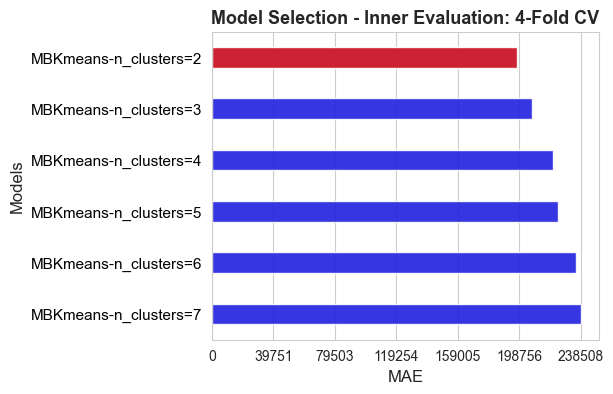

The best model among all the 6 alternatives plotted, according to the inner evaluation, is: MBKmeans-n_clusters=2
MAE of the best model: 197053.161

The best model hyper-parameters are: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'features_selector__method': nan, 'preprocessing__quant__scaler__method': nan, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 98, 'clustering_model__estimators__0__max_depth': 40.0, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 7.0, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimat

In [37]:
fig, axes = plt.subplots(figsize=(5,4))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('MAE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=11)    
plt.title(f'Model Selection - Inner Evaluation: 4-Fold CV', size=13, weight='bold')
for label in ax.get_yticklabels():
    label.set_color('black') 
plt.show()

print(f'The best model among all the {len(sorted_scores)} alternatives plotted, according to the inner evaluation, is: {best_pipeline}')
print('MAE of the best model:', np.round(score_best_pipeline, 3))
print('\nThe best model hyper-parameters are:', best_params_large[best_pipeline])